In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict


In [2]:
# Đọc dữ liệu từ file .csv
dataset_path = '/content/sentiment_analysis.csv'  # Đường dẫn tới file dữ liệu
df = pd.read_csv(dataset_path, index_col='id')


In [3]:
def text_normalize(text):
    # Loại bỏ từ viết tắt "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # Loại bỏ đường dẫn
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # Loại bỏ hashtag
    text = re.sub(r'#', '', text)
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    text_tokens = tokenizer.tokenize(text)
    return text_tokens


In [4]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for _, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    return freqs


In [5]:
def get_feature(text, freqs):
    tokens = text_normalize(text)
    X = np.zeros(3)  # Vector có 3 phần tử (intercept, n_positives, n_negatives)
    X[0] = 1  # intercept
    for token in tokens:
        X[1] += freqs[(token, 0)]  # Đếm số từ negative
        X[2] += freqs[(token, 1)]  # Đếm số từ positive
    return X


In [6]:
X = []
y = []

freqs = get_freqs(df)
for _, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']
    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)


In [7]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

# Chia tập `train` và `val`
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)

# Chia tiếp tập `train` thành `train` và `test`
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


In [8]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])


In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc


In [10]:
lr = 0.01
epochs = 200
batch_size = 128  # Tăng batch_size cho tốc độ huấn luyện nhanh hơn

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])


In [11]:
# Huấn Luyện Mô Hình
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        # Dự đoán
        y_hat = predict(X_i, theta)

        # Tính loss
        train_loss = compute_loss(y_hat, y_i)

        # Tính gradient
        gradient = compute_gradient(X_i, y_i, y_hat)

        # Cập nhật theta
        theta = update_theta(theta, gradient, lr)

        # Lưu loss của batch hiện tại
        train_batch_losses.append(train_loss)

    # Tính độ chính xác cho tập train và val
    train_acc = compute_accuracy(X_train, y_train, theta)
    val_acc = compute_accuracy(X_val, y_val, theta)

    train_batch_accs.append(train_acc)
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)
    val_batch_accs.append(val_acc)

    # Tính trung bình loss và accuracy cho từng epoch
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    # Lưu loss và accuracy vào danh sách toàn cục
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    # In ra loss và accuracy cho mỗi epoch
    print(f'\nEPOCH {epoch + 1}: Training loss: {train_batch_loss:.3f} Validation loss: {val_batch_loss:.3f}')


EPOCH 1: Training loss: 0.707 Validation loss: 0.681

EPOCH 2: Training loss: 0.661 Validation loss: 0.640

EPOCH 3: Training loss: 0.624 Validation loss: 0.606

EPOCH 4: Training loss: 0.594 Validation loss: 0.578

EPOCH 5: Training loss: 0.569 Validation loss: 0.556

EPOCH 6: Training loss: 0.548 Validation loss: 0.537

EPOCH 7: Training loss: 0.531 Validation loss: 0.521

EPOCH 8: Training loss: 0.516 Validation loss: 0.508

EPOCH 9: Training loss: 0.504 Validation loss: 0.496

EPOCH 10: Training loss: 0.494 Validation loss: 0.487

EPOCH 11: Training loss: 0.485 Validation loss: 0.479

EPOCH 12: Training loss: 0.477 Validation loss: 0.472

EPOCH 13: Training loss: 0.471 Validation loss: 0.465

EPOCH 14: Training loss: 0.465 Validation loss: 0.460

EPOCH 15: Training loss: 0.460 Validation loss: 0.455

EPOCH 16: Training loss: 0.456 Validation loss: 0.451

EPOCH 17: Training loss: 0.452 Validation loss: 0.447

EPOCH 18: Training loss: 0.448 Validation loss: 0.444

EPOCH 19: Training

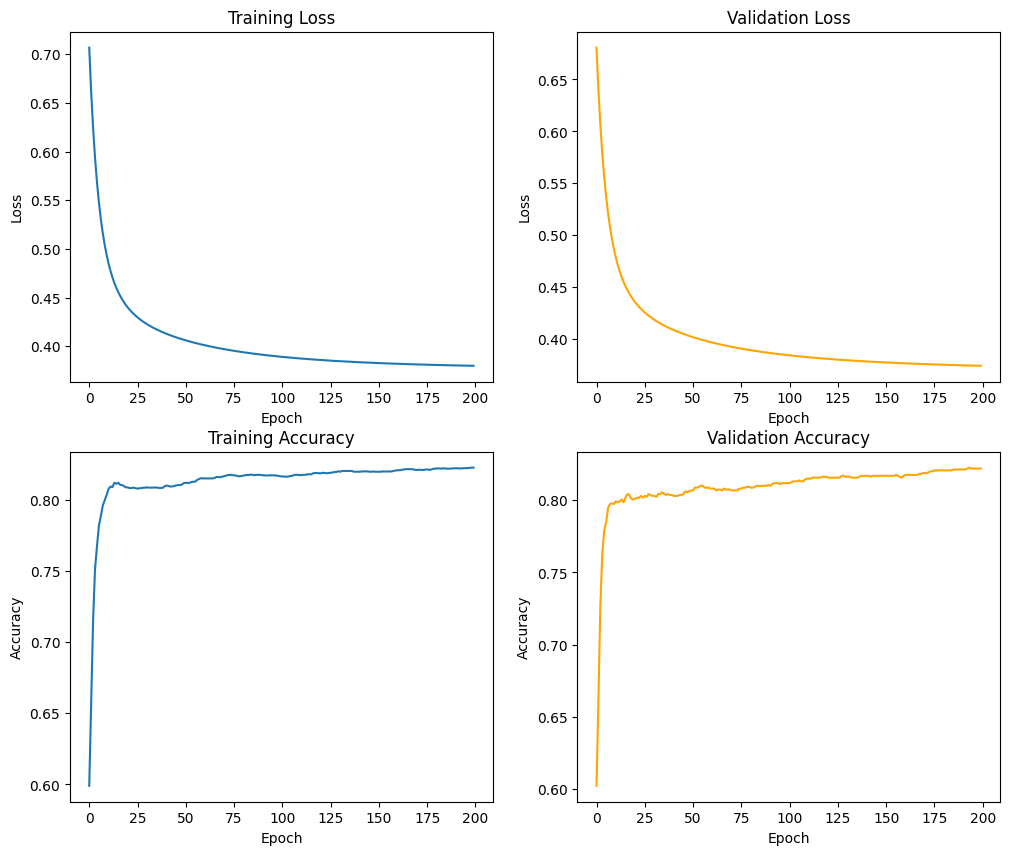

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Biểu đồ Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Biểu đồ Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Biểu đồ Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Biểu đồ Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [13]:

val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation Accuracy: {val_set_acc}')
print(f'Test Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Validation Accuracy: 0.821969696969697
Test Accuracy: 0.8434343434343434
